In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L2

from dataloader_v1 import SpectDataset

In [3]:
tf.__version__

'2.5.0'

In [4]:
seed = 123
tf.random.set_seed(seed)

In [5]:
DATA_PATH = 'D:\\SP Cup 2022\\New folder\\spcup_2022_training_part1'
Labeled_dir = 'D:\\SP Cup 2022\\New folder\\spcup_2022_training_part1\\labels.csv'

In [39]:
# DATA_PATH = 'D:\\SP Cup 2022\\New folder\\spcup_2022_unseen'
# Labeled_dir = 'D:\\SP Cup 2022\\New folder\\spcup_2022_unseen\\labels.csv'

In [6]:
dataloader = SpectDataset(add_noise=True)
train_ds, val_ds = dataloader.call(DATA_PATH, Labeled_dir)

In [7]:
def SBCNN_Model(input_shape, num_labels):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(24, 5, padding='same'))
    model.add(MaxPool2D(strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, 5, padding='same'))
    model.add(MaxPool2D(strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, 5, padding='valid'))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_regularizer=L2(0.001)))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, kernel_regularizer=L2(0.001)))
    model.add(Activation('softmax'))

    return model

In [8]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (32, 124, 129, 1)


In [9]:
model = SBCNN_Model(input_shape[1:], 6)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [11]:
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
150/150 [==============================] - 90s 95ms/step - loss: 1.7486 - accuracy: 0.3096 - val_loss: 1.3182 - val_accuracy: 0.5342
Epoch 2/15
150/150 [==============================] - 5s 34ms/step - loss: 1.3589 - accuracy: 0.4923 - val_loss: 1.0607 - val_accuracy: 0.6458
Epoch 3/15
150/150 [==============================] - 5s 34ms/step - loss: 1.1589 - accuracy: 0.5788 - val_loss: 0.9596 - val_accuracy: 0.6483
Epoch 4/15
150/150 [==============================] - 5s 34ms/step - loss: 1.0560 - accuracy: 0.6177 - val_loss: 0.8789 - val_accuracy: 0.6883
Epoch 5/15
150/150 [==============================] - 5s 34ms/step - loss: 0.9772 - accuracy: 0.6538 - val_loss: 0.8162 - val_accuracy: 0.7117
Epoch 6/15
150/150 [==============================] - 5s 34ms/step - loss: 0.9089 - accuracy: 0.6837 - val_loss: 0.7566 - val_accuracy: 0.7308
Epoch 7/15
150/150 [==============================] - 5s 34ms/step - loss: 0.8664 - accuracy: 0.6967 - val_loss: 0.7343 - val_accuracy: 0.745

__Model training visualization__

In [13]:
import matplotlib.pyplot as plt

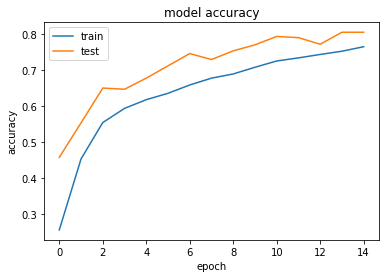

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

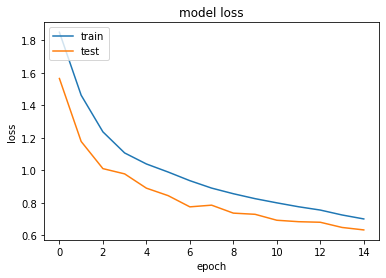

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Sample Evaluation pipeline building__

_extracting y_pred and y_true values_

In [16]:
import numpy as np

In [17]:
res_sparse = model.predict(val_ds)

In [18]:
res_np = np.argmax(res_sparse, axis=1)
pred_labels = list(res_np)

In [19]:
true_labels = []
for _, label in val_ds.take(1000):
    true_labels.extend(list(label.numpy()))

In [20]:
from sklearn.metrics import classification_report

_class-wise analysis_

In [22]:
class_names = [f'class_{i}' for i in range(6)]
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

     class_0       0.98      0.99      0.98       200
     class_1       0.55      0.81      0.66       200
     class_2       0.75      0.52      0.61       200
     class_3       0.95      0.93      0.94       200
     class_4       0.99      0.98      0.99       200
     class_5       0.71      0.60      0.65       200

    accuracy                           0.81      1200
   macro avg       0.82      0.81      0.80      1200
weighted avg       0.82      0.81      0.80      1200



_confusion metrics_

In [23]:
import matplotlib.pyplot as plt
import itertools

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
from sklearn import metrics

Confusion matrix, without normalization


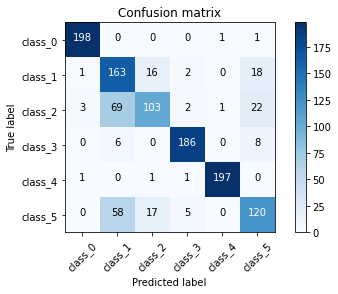

In [26]:
cm = metrics.confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, classes=class_names)


_overall analysis_

_Jaccard metrics_

In [27]:
# Jaccard metrics - macro
from sklearn.metrics import jaccard_score
jaccard_score(true_labels, pred_labels, average='macro')

0.7064006015845249

In [28]:
# F1 - macro
from sklearn.metrics import f1_score
f1_score(true_labels, pred_labels, average='macro')

0.804738902833142

In [29]:
# precision - macro
from sklearn.metrics import precision_score
precision_score(true_labels, pred_labels, average='macro')

0.8211430772500149

In [30]:
# recall - macro
from sklearn.metrics import recall_score
recall_score(true_labels, pred_labels, average='macro')

0.8058333333333333

In [31]:
# Cohen's Kappa metrics
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(true_labels, pred_labels)

0.767

In [32]:
# matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(true_labels, pred_labels)

0.7715696507533396

__Model result interoperability__

In [33]:
import pandas as pd
label_df = pd.read_csv(Labeled_dir)

In [34]:
label_df.head()

SyntaxError: unexpected EOF while parsing (49405172.py, line 1)

In [73]:
label_df.groupby('algorithm').count()

,track
algorithm,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
